In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from tabulate import tabulate
from sklearn.pipeline import Pipeline
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [3]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [4]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
df = pd.merge(train, test, how='outer')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


###File and Data Field Descriptions

***train.csv*** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

***PassengerId*** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

***HomePlanet*** - The planet the passenger departed from, typically their planet of permanent residence.

***CryoSleep*** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

***Cabin*** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

***Destination*** - The planet the passenger will be debarking to.

***Age*** - The age of the passenger.

***VIP*** - Whether the passenger has paid for special VIP service during the voyage.

***RoomService, FoodCourt, ShoppingMall, Spa, VRDeck*** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

***Name*** - The first and last names of the passenger.

***Transported*** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,12700.000,28.772,14.387,0.000,19.000,27.000,38.000,79.000
RoomService,12707.000,222.898,647.597,0.000,0.000,0.000,49.000,14327.000
FoodCourt,12681.000,451.962,1584.371,0.000,0.000,0.000,77.000,29813.000
ShoppingMall,12664.000,174.906,590.559,0.000,0.000,0.000,29.000,23492.000
Spa,12686.000,308.477,1130.280,0.000,0.000,0.000,57.000,22408.000
VRDeck,12702.000,306.789,1180.097,0.000,0.000,0.000,42.000,24133.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [8]:
df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [9]:
numeric = df.select_dtypes(include=['number']).columns
print(df[numeric].quantile([0,0.01,0.05,0.25,0.50,0.75,0.95,0.99,1]).T)

              0.000  0.010  0.050  0.250  0.500  0.750    0.950    0.990  \
Age           0.000  0.000  4.000 19.000 27.000 38.000   56.000   65.010   
RoomService   0.000  0.000  0.000  0.000  0.000 49.000 1275.800 3009.520   
FoodCourt     0.000  0.000  0.000  0.000  0.000 77.000 2670.000 7797.600   
ShoppingMall  0.000  0.000  0.000  0.000  0.000 29.000  964.250 2396.740   
Spa           0.000  0.000  0.000  0.000  0.000 57.000 1589.000 5435.900   
VRDeck        0.000  0.000  0.000  0.000  0.000 42.000 1538.800 5838.930   

                 1.000  
Age             79.000  
RoomService  14327.000  
FoodCourt    29813.000  
ShoppingMall 23492.000  
Spa          22408.000  
VRDeck       24133.000  


In [10]:
dff = df.copy()

In [11]:
dff.fillna(method='ffill', inplace=True) 

In [12]:
dff.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'object']
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'object']
    
    cat_but_car = [col for col in cat_cols if dataframe[col].nunique() > car_th]
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_but_cat = [col for col in num_cols if dataframe[col].nunique() < cat_th]
    
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, cat_but_car, num_cols

In [14]:
cat_cols,cat_but_car,num_cols = grab_col_names(dff)

Observations: 12970
Variables: 14
cat_cols: 2
num_cols: 6
cat_but_car: 3
num_but_cat: 3


In [15]:
def cat_summary(dataframe, col_name, plot=False):
    summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                               "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})
    print(summary_df)

    if plot:
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

            HomePlanet  Ratio
HomePlanet                   
Earth             7024 54.156
Europa            3200 24.672
Mars              2746 21.172


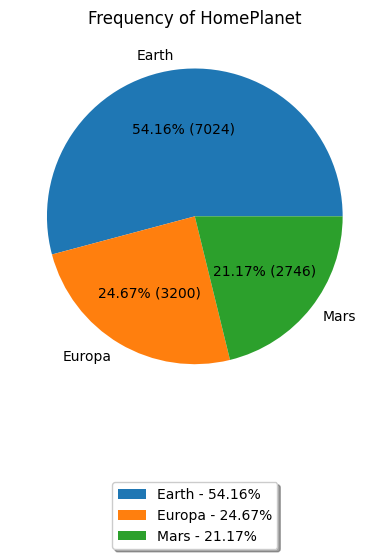

               Destination  Ratio
Destination                      
TRAPPIST-1e           9055 69.815
55 Cancri e           2701 20.825
PSO J318.5-22         1214  9.360


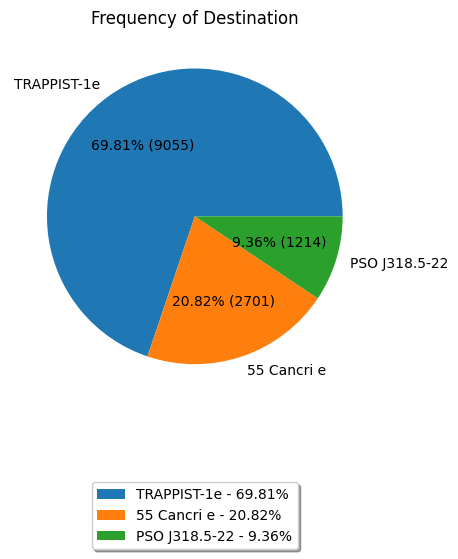

In [16]:
for col in cat_cols:
    cat_summary(dff, col, True)

In [17]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        fig = px.histogram(dataframe, x=numerical_col, nbins=50, labels={numerical_col: "Value"})
        fig.update_layout(title=numerical_col + " Distribution")
        fig.show()

    print("-------------------------------------------------------")

In [18]:
for col in num_cols:
    num_summary(dff, col, True)

count   12970.000
mean       28.756
std        14.395
min         0.000
5%          4.000
10%        13.000
20%        18.000
30%        21.000
40%        24.000
50%        27.000
60%        30.000
70%        35.000
80%        41.000
90%        49.000
95%        56.000
99%        65.000
max        79.000
Name: Age, dtype: float64


-------------------------------------------------------
count   12970.000
mean      223.255
std       646.063
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         8.000
80%       181.000
90%       767.000
95%      1277.000
99%      3004.480
max     14327.000
Name: RoomService, dtype: float64


-------------------------------------------------------
count   12970.000
mean      451.496
std      1581.249
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%        12.000
80%       259.200
90%      1014.100
95%      2659.800
99%      7814.430
max     29813.000
Name: FoodCourt, dtype: float64


-------------------------------------------------------
count   12970.000
mean      174.694
std       590.126
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         5.000
80%        98.200
90%       622.100
95%       965.550
99%      2384.240
max     23492.000
Name: ShoppingMall, dtype: float64


-------------------------------------------------------
count   12970.000
mean      308.233
std      1127.607
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%        15.000
80%       180.000
90%       734.000
95%      1589.000
99%      5440.060
max     22408.000
Name: Spa, dtype: float64


-------------------------------------------------------
count   12970.000
mean      307.396
std      1184.827
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         7.000
80%       140.000
90%       723.000
95%      1527.800
99%      5867.170
max     24133.000
Name: VRDeck, dtype: float64


-------------------------------------------------------


In [19]:
def calculate_target_mean(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))

In [20]:
for col in cat_cols:
    calculate_target_mean(df, "Transported", col)

           TARGET_MEAN
HomePlanet            
Earth            0.424
Europa           0.659
Mars             0.523
              TARGET_MEAN
Destination              
55 Cancri e         0.610
PSO J318.5-22       0.504
TRAPPIST-1e         0.471


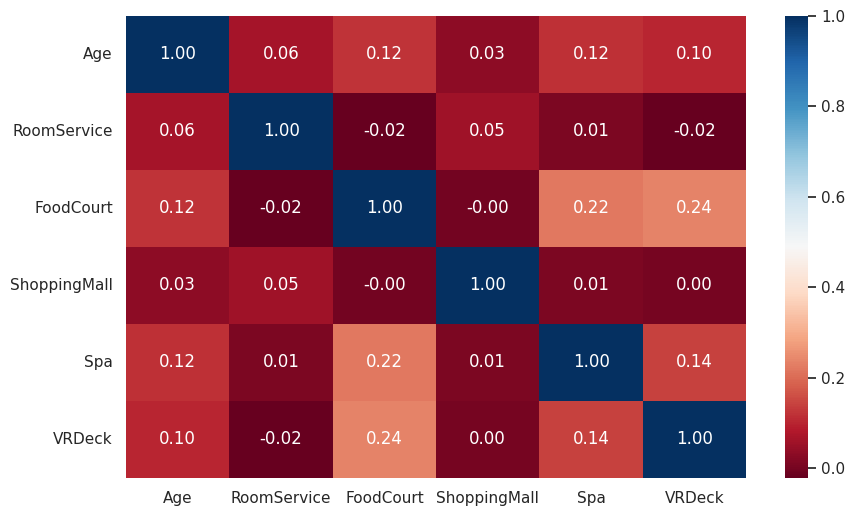

In [21]:
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns

num_cols = [col for col in num_cols if col not in non_numeric_cols]

corr = dff[num_cols].corr()

sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")
plt.show()

In [22]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    low_limit, up_limit = dataframe[variable].quantile([low_quantile, up_quantile])
    interquantile_range = up_limit - low_limit
    up_limit += 1.5 * interquantile_range
    low_limit -= 1.5 * interquantile_range
    return low_limit, up_limit

In [23]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[col_name].between(low_limit, up_limit).any()

In [24]:
for col in num_cols:
    if col != "Transported":
      print(col, check_outlier(df, col))

Age True
RoomService True
FoodCourt True
ShoppingMall True
Spa True
VRDeck True


In [25]:
def parse_cabin(cabin):
    if pd.isnull(cabin):
        return None, None, None
    
    cabins = cabin.split('/')
    deck = cabins[0]
    num = cabins[1]
    side = cabins[2]
    return deck, num, side

dff['Deck'], dff['Num'], dff['Side'] = zip(*dff['Cabin'].apply(parse_cabin))

dff.drop('Cabin', axis=1, inplace=True)

print(dff.head())

  PassengerId HomePlanet  CryoSleep  Destination    Age    VIP  RoomService  \
0     0001_01     Europa      False  TRAPPIST-1e 39.000  False        0.000   
1     0002_01      Earth      False  TRAPPIST-1e 24.000  False      109.000   
2     0003_01     Europa      False  TRAPPIST-1e 58.000   True       43.000   
3     0003_02     Europa      False  TRAPPIST-1e 33.000  False        0.000   
4     0004_01      Earth      False  TRAPPIST-1e 16.000  False      303.000   

   FoodCourt  ShoppingMall      Spa  VRDeck               Name  Transported  \
0      0.000         0.000    0.000   0.000    Maham Ofracculy        False   
1      9.000        25.000  549.000  44.000       Juanna Vines         True   
2   3576.000         0.000 6715.000  49.000      Altark Susent        False   
3   1283.000       371.000 3329.000 193.000       Solam Susent        False   
4     70.000       151.000  565.000   2.000  Willy Santantines         True   

  Deck Num Side  
0    B   0    P  
1    F   0    

In [26]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  bool   
 3   Destination   12970 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  bool   
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  Name          12970 non-null  object 
 12  Transported   12970 non-null  bool   
 13  Deck          12970 non-null  object 
 14  Num           12970 non-null  object 
 15  Side          12970 non-null  object 
dtypes: bool(3), float64(6), object(7)
memory usage: 1.3+ MB


In [27]:
target_column = dff['Transported']
dff.drop('Transported', axis=1, inplace=True)

In [28]:
cat_cols, cat_but_car, num_cols = grab_col_names(dff)

def label_encoder(dataframe, binary_col):
    labelencoder =  LabelEncoder()
    dataframe[binary_col] = labelencoder.fittransform(dataframe[binary_col])
    return dataframe

Observations: 12970
Variables: 15
cat_cols: 4
num_cols: 6
cat_but_car: 3
num_but_cat: 2


In [29]:
dff.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,F,1,S


In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    return pd.get_dummies(dataframe,columns=categorical_cols, drop_first=drop_first)

dfx = one_hot_encoder(dff, cat_cols, drop_first=True)

In [31]:
binary_cols = [col for col in dfx.columns if dfx[col].dtypes == '0' and len(dfx[col].unique()) == 2]

for col in binary_cols:
    label_encoder(dfx, col)

In [32]:
binary_cols

[]

In [33]:
dfx = pd.concat([dfx, target_column], axis=1)

In [34]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  object 
 1   CryoSleep                  12970 non-null  bool   
 2   Age                        12970 non-null  float64
 3   VIP                        12970 non-null  bool   
 4   RoomService                12970 non-null  float64
 5   FoodCourt                  12970 non-null  float64
 6   ShoppingMall               12970 non-null  float64
 7   Spa                        12970 non-null  float64
 8   VRDeck                     12970 non-null  float64
 9   Name                       12970 non-null  object 
 10  Num                        12970 non-null  object 
 11  HomePlanet_Europa          12970 non-null  bool   
 12  HomePlanet_Mars            12970 non-null  bool   
 13  Destination_PSO J318.5-22  12970 non-null  boo

In [35]:
dfx[dfx.select_dtypes(include='bool').columns] = dfx.select_dtypes(include='bool').astype(int)

In [36]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  object 
 1   CryoSleep                  12970 non-null  int64  
 2   Age                        12970 non-null  float64
 3   VIP                        12970 non-null  int64  
 4   RoomService                12970 non-null  float64
 5   FoodCourt                  12970 non-null  float64
 6   ShoppingMall               12970 non-null  float64
 7   Spa                        12970 non-null  float64
 8   VRDeck                     12970 non-null  float64
 9   Name                       12970 non-null  object 
 10  Num                        12970 non-null  object 
 11  HomePlanet_Europa          12970 non-null  int64  
 12  HomePlanet_Mars            12970 non-null  int64  
 13  Destination_PSO J318.5-22  12970 non-null  int

In [37]:
for col in dfx.select_dtypes(include='bool').columns:
    print(col, dfx[col].unique())

In [38]:
y = dfx['Transported']
X = dfx.drop(['Transported','PassengerId'], axis=1)

In [39]:
X = pd.get_dummies(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [41]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [42]:
y_pred = lr.predict(X_test)

In [43]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred))
print('Precision','%.3f' % precision_score(y_test, y_pred))
print('Recall','%.3f' % recall_score(y_test, y_pred))
print('F1 Score','%.3f' % f1_score(y_test, y_pred))

Accuracy 0.699
Precision 0.699
Recall 0.669
F1 Score 0.683


### Naives Bayes

In [44]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [45]:
y_pred_gnb = gnb.predict(X_test)

In [46]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_gnb))
print('Precision','%.3f' % precision_score(y_test, y_pred_gnb))
print('Recall','%.3f' % recall_score(y_test, y_pred_gnb))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_gnb))

Accuracy 0.570
Precision 0.550
Recall 0.627
F1 Score 0.586


### K-Nearest Neighbors(KNN)

In [47]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
y_pred_knn = knn.predict(X_test)

In [49]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_knn))
print('Precision','%.3f' % precision_score(y_test, y_pred_knn))
print('Recall','%.3f' % recall_score(y_test, y_pred_knn))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_knn))

Accuracy 0.663
Precision 0.648
Recall 0.673
F1 Score 0.660


In [50]:
f1s = []
for i in range(1, 40):
    knnx = KNeighborsClassifier(n_neighbors=i)
    knnx.fit(X_train, y_train)
    pred_i = knnx.predict(X_test)
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

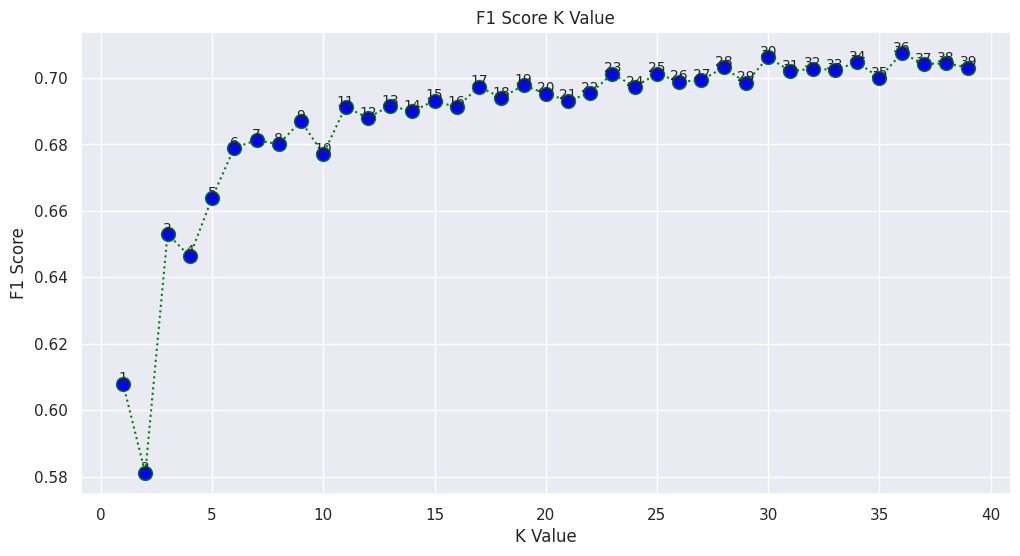

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1s,
         color='green',
         linestyle='dotted',
         marker='o',
         markerfacecolor='blue',
         markersize=10)

plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

for i, f1 in enumerate(f1s, start=1):
    plt.text(i, f1 + 0.0016, str(i), ha='center', va='center', fontsize=10)

In [52]:
knn_best = KNeighborsClassifier(n_neighbors=36)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=36)

In [53]:
y_pred_knn_best=knn_best.predict(X_test)

In [54]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_knn_best))
print('Precision','%.3f' % precision_score(y_test, y_pred_knn_best))
print('Recall','%.3f' % recall_score(y_test, y_pred_knn_best))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_knn_best))

Accuracy 0.707
Precision 0.693
Recall 0.712
F1 Score 0.702


### Support Vector Machine

In [55]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [56]:
y_pred_svc = svc.predict(X_test)

In [57]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_svc))
print('Precision','%.3f' % precision_score(y_test, y_pred_svc))
print('Recall','%.3f' % recall_score(y_test, y_pred_svc))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_svc))

Accuracy 0.699
Precision 0.656
Recall 0.801
F1 Score 0.721


In [58]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
dtc = DecisionTreeClassifier()
dtc.fit(X_c_train, y_c_train)

DecisionTreeClassifier()

In [60]:
y_pred_cart = dtc.predict(X_c_test)

In [61]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_cart))
print('Precision','%.3f' % precision_score(y_test, y_pred_cart))
print('Recall','%.3f' % recall_score(y_test, y_pred_cart))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_cart))

Accuracy 0.660
Precision 0.641
Recall 0.679
F1 Score 0.659


### Random Forest

In [62]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
rfc = RandomForestClassifier()
rfc.fit(X_rf_train,y_rf_train)

RandomForestClassifier()

In [64]:
y_pred_rfc = rfc.predict(X_rf_test)

In [65]:
print('Accuracy','%.3f' % accuracy_score(y_test, y_pred_rfc))
print('Precision','%.3f' % precision_score(y_test, y_pred_rfc))
print('Recall','%.3f' % recall_score(y_test, y_pred_rfc))
print('F1 Score','%.3f' % f1_score(y_test, y_pred_rfc))

Accuracy 0.711
Precision 0.709
Recall 0.685
F1 Score 0.697


### Logistic Regression

Accuracy 0.699
Precision 0.699
Recall 0.669
F1 Score 0.683

### Naive Bayes

Accuracy 0.570
Precision 0.550
Recall 0.627
F1 Score 0.586

### KNN

Accuracy 0.707
Precision 0.693
Recall 0.712
F1 Score 0.702

### SVC

Accuracy 0.699
Precision 0.656
Recall 0.801
F1 Score 0.721

### CART

Accuracy 0.661
Precision 0.638
Recall 0.696
F1 Score 0.666

### Random Forest

Accuracy 0.708
Precision 0.710
Recall 0.674
F1 Score 0.691
